**Complex-valued analytical approach to Kuramoto dynamics**

This Collab contains code demonstrating the complex-valued approach to the Kuramoto model introduced in:

[Budzinski\*, Nguyen\*, Đoàn, Mináč, Sejnowski, Muller. Geometry unites synchrony, chimeras, and waves in nonlinear oscillator networks. Chaos, 2022 (*equal contribution)](https://aip.scitation.org/doi/full/10.1063/5.0078791).

In these works, we developed an analytical approach to the Kuramoto model. The fundamental idea is to analyze a complex-valued system, closely related to the formulation of the original, nonlinear Kuramoto model defined in the real numbers. We find the complex-valued system can be exactly solved and, by iterating this explicit expression over short intervals, the trajectories of the two systems precisely match for long times. The advantage of this approach is that it can describe the full nonlinear dynamics in the Kuramoto model as the combination of two operators: the matrix exponential and an elementwise nonlinearity. This description allows us to directly connect the nonlinear dynamics in an individual simulation (either a single network taken from data, or a single realization of a random graph) to the spectrum of the adjacency matrix. This, in turn, provides an opportunity to describe sychronization dynamics in this system (phase synchronization, traveling waves, and chimeras) in terms of the eigenmodes of the system (Budzinski\*, Nguyen\* et al., Chaos, 2022).

---

In [1]:
# @title Importing libraries
# Imports
import numpy as np
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from scipy.linalg import expm

Ring graph: N nodes and each node is connected to k nearest neighbors. The following function generates an adjacency matrix for a ring graph.

In [2]:
# Connectivity function (ring graph)
# Function to generate a ring graph on N nodes with degree 2k
def ring_graph(N, k):

    # Initializing the adjacency matrix
    A = np.zeros((N, N), dtype=bool)

    # Generating the values that will be used to modify the index in the ring graph
    m = list(range(-k, k+1))
    m.remove(0)

    # Generating the ring graph
    for ii in range(N):
        for jj in m:
            # Modifying the index to create the ring structure and filling the adjacency matrix
            A[ii, (ii+jj) % N] = 1

    return A

#### **Connectivity function (distance-dependent graph)**

In [3]:

# Function to generate a distance-dependent graph on N nodes with power-law decay with exponent alpha
def distance_dependent_graph(N, alpha):

    # Initializing the adjacency matrix with zeros and distance matrix with NaN
    A = np.zeros((N, N))
    d = np.full((N, N), np.nan)

    # Filling the distance matrix
    for ii in range(N):
        for jj in range(N):
            if ii == jj:
                continue
            dist = abs(ii - jj)
            d[ii, jj] = min(dist, N - dist) # need to consider the shortest path

    # Calculating the eta value (normalization factor) -> row sum of the matrix will be 1
    eta = np.nansum(1.0 / d[0, :]**alpha)

    # Filling the adjacency matrix
    A = (1.0 / eta) * (1.0 / d**alpha)

    # Setting the diagonal elements to zero
    for ii in range(N):
        A[ii, ii] = 0

    return A

#### **Function to numerically simulate the KM**

Define the function to numerically simulate the KM (integrate the ODE) -> essentially Euler method. 

Could use better numerical integration method, but this is the simplest and is sufficient for a simple system like this. (The error is approx 10^-4, which in my opinion is kinda high...)

In [4]:
def km_simulation(w, omega, epsilon, theta0, time, dt, phi):

    N = w.shape[0]
    theta = np.zeros((len(time), N)) # initialize the theta array 
    theta[0, :] = theta0 # initial condition

    for ii in range(1, len(time)):
        previous_state = theta[ii - 1, :]

        # update the theta array (Euler step)
        for jj in range(N):
            dth = omega[jj] + epsilon * np.nansum(w[jj, :] * np.sin(previous_state - previous_state[jj] - phi))
            theta[ii, jj] = previous_state[jj] + (dth * dt)

    # Wrap theta into [-pi, pi]
    theta = np.angle(np.exp(1j * theta))

    return theta

#### **Function to evaluate CDT**

Circulum diagonalization theorem (CDT) - diagonalize the adjacency matrix using the circulant matrix. An analytical method to diagonalize the adjacency matrix. Links the eigenvales/vectors to the Fourier modes which has a direct relationship to the dynamics of the system.

A circulant matrix is a matrix where each row is a circular shift of the previous row.

Examples: (adjacency matrix of)
- Ring graph
- Distance-dependent graph


Evaluate the CDT (eigenvalues and eigenvectors of the adjacency matrix)

In [5]:
# Function to evaluate CDT
def circulant_eigensystem(a):

    N = a.shape[0]  # Get the size of the square matrix a

    # Initializing eigenvectors and eigenvalues matrices
    v = np.zeros((N, N), dtype=complex)
    d = np.zeros((N, N), dtype=complex)

    # Calculate eigenvectors
    for ii in range(N):
        for jj in range(N):
            v[ii, jj] = np.round((1/np.sqrt(N)) * np.exp(-2j * np.pi / N * ii * jj),6)

    # Calculate eigenvalues
    for ii in range(N):
        d[ii, ii] = np.round(sum(a[0, :] * np.exp(-2j * np.pi / N * ii * np.arange(N))),6)

    return v, d

#### **Evaluate the order parameter**

Order parameter is a measure of the synchronization of the system. It is the sum of the complex exponentials of the phases of the oscillators divided by the number of oscillators.

- Order parameter = 0 -> No synchronization (as N -> infinity)
- Order parameter = 1 -> Full synchronization (all oscillators are in phase)

In [6]:
# @title Function to evaluate the order parameter
def order_parameter(theta_num,N):

    r = np.abs(np.sum(np.exp(1j*theta_num),1))/N
    return r

In the first example, we consider the traditional transition from random initial conditions to phase synchronization

In [7]:
# @title Defining parameters
# Parameters
dt = 0.001                    # time step (of integration)
T = 5.0                       # total time of integration ("seconds")
t = np.arange(0, T + dt, dt)  # Time array

N = 100                       # Number of oscillators in the network
epsilon = 0.05                # Coupling strength
phi = 0                       # Phase-lag
f_mu = 5                      # Natural frequency (Hz)
omega = np.ones((N, 1)) * f_mu * 2 * np.pi  # Natural frequency array

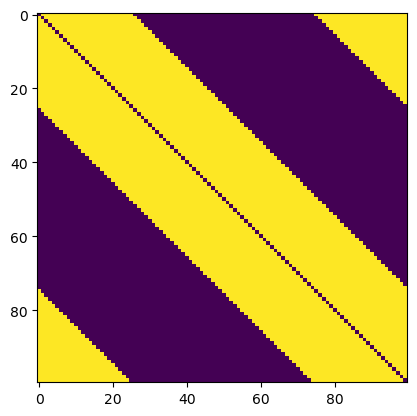

In [8]:
# @title Creating network
# Adjacency matrix
k = 25; #2k is the degree (2k = degree of the network)
a = ring_graph(N,k)

plt.figure()
plt.imshow(a)

Yellow = connected nodes, Blue = disconnected nodes. Diagonal is 0 (no self-coupling).

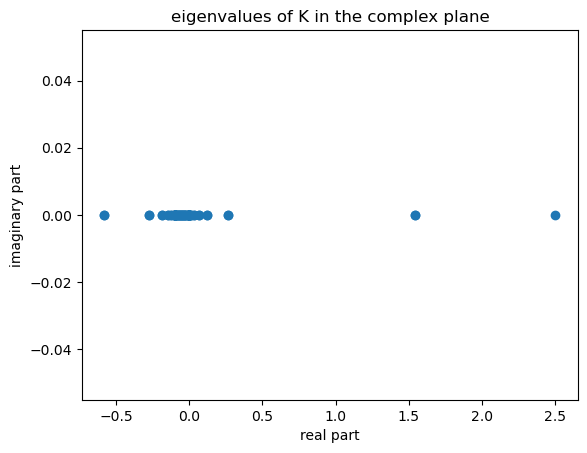

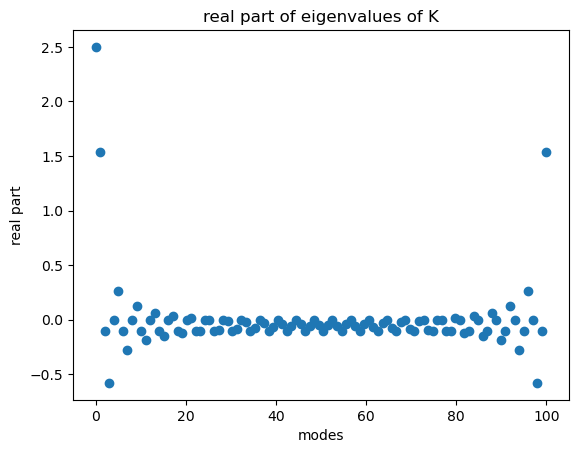

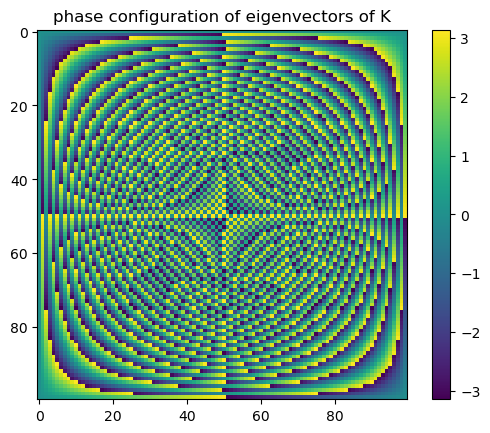

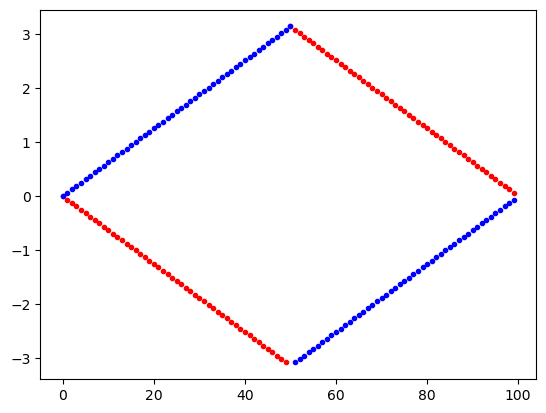

In [10]:
# @title Complex-valued matrix analysis

# Matrix representing the complex system
K = epsilon * np.exp(-1j * phi) * a

# Eigensystem
v, d = circulant_eigensystem(K)

plt.figure()
plt.scatter(np.diag(np.real(d)), np.diag(np.imag(d)))
plt.xlabel('real part')
plt.ylabel('imaginary part')
plt.title('eigenvalues of K in the complex plane')

plt.figure()
plt.scatter(np.linspace(0,N,N),np.diag(np.real(d)))
plt.xlabel('modes')
plt.ylabel('real part')
plt.title('real part of eigenvalues of K')

plt.figure()
plt.imshow(np.angle(v))
plt.title('phase configuration of eigenvectors of K')
plt.colorbar()

plt.figure()
plt.plot( np.angle(v[:,1]), 'r.' )
plt.plot( np.angle(v[:,99]), 'b.' )

#### **Numerical simulation of the KM**

In [11]:
# @title Numerical simulation of the KM
# Initial condition (random initial conditions)
theta0 = 2 * np.pi * (np.random.rand(N, 1) - 0.5)

# numerical simulation of the Kuramoto network
theta_numerical = km_simulation(a, omega, epsilon, theta0.transpose(), t, dt, phi)

/tmp/ipykernel_53854/3325396489.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta[ii, jj] = previous_state[jj] + (dth * dt)


In [12]:
# @title Evaluation of the complex-valued approach
# Evaluate complex-valued approach (propagator)
x = np.zeros((len(t), N), dtype=complex)
theta_cv = np.zeros((len(t), N))
theta_cv[0,:] = theta0.transpose()
x[0, :] = np.exp(1j * theta0.flatten())  # Initial condition for the first window
propagate = np.exp(1j * (omega[1] * dt)) * expm(K*dt)

for jj in range(1, len(t)):
    previous_state = np.angle(x[jj - 1, :])
    x[jj, :] = np.dot(propagate , np.exp(1j * previous_state))
    theta_cv[jj,:] = np.angle(x[jj, :]/np.abs(x[jj,:]))

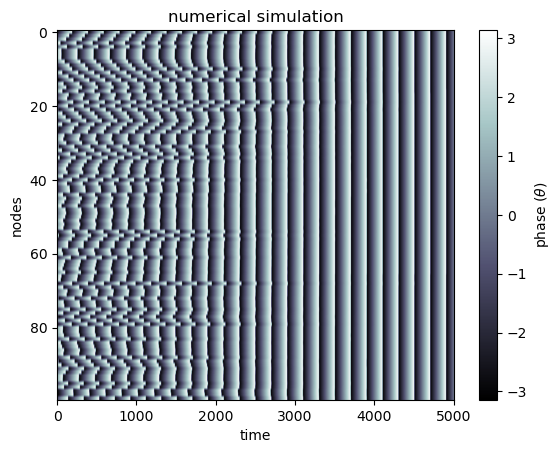

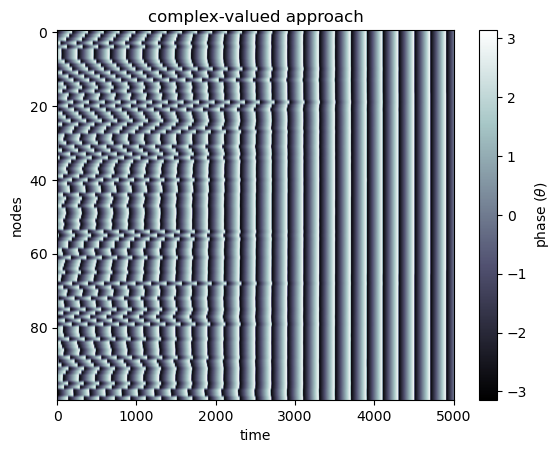

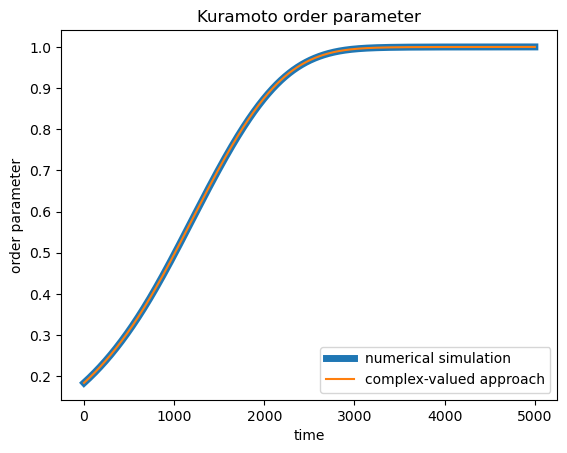

In [17]:
# @title Visualization of the dynamics
# visualization of the dynamics
plt.figure()
plt.imshow(np.transpose(theta_numerical), aspect='auto', cmap = 'bone')
plt.xlabel('time')
plt.ylabel('nodes')
plt.colorbar(label='phase ($\\theta$)')
plt.title('numerical simulation')

plt.figure()
plt.imshow(np.transpose(theta_cv), aspect='auto', cmap = 'bone')
plt.xlabel('time')
plt.ylabel('nodes')
plt.colorbar(label='phase ($\\theta$)')
plt.title('complex-valued approach')


#order parameter
r_num = order_parameter(theta_numerical,N)
r_cv = order_parameter(theta_cv,N)
plt.figure()
plt.plot(r_num, linewidth=5, label='numerical simulation')
plt.plot(r_cv, label='complex-valued approach')
plt.title('Kuramoto order parameter')
plt.xlabel('time')
plt.ylabel('order parameter')
plt.legend()


In the second example, we consider the emergence of traveling waves in the network. We do this by changing the connectivity of the network.

Now each node is only connected to one other node on each side. (used to be 25 on each side)

In [18]:
# @title Defining parameters
# Parameters
dt = 0.001
T = 5.0
t = np.arange(0, T + dt, dt)  # Time array
N = 100                       # Number of oscillators
epsilon = 2                   # Coupling strength
phi = 0                       # Phase-lag
f_mu = 5                      # Natural frequency (Hz)
omega = np.ones((N, 1)) * f_mu * 2 * np.pi  # Natural frequency array

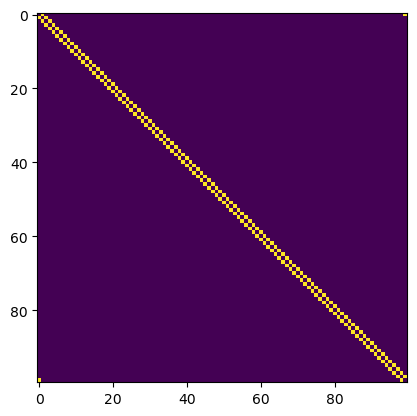

In [20]:
# @title Creating network
# Adjacency matrix
k = 1; #2k is the degree
a = ring_graph(N,k)

plt.figure()
plt.imshow(a)

Observe the very sparse matrix above (only 2 connections per node). 

Text(0.5, 1.0, 'phase configuration of eigenvectors of K')

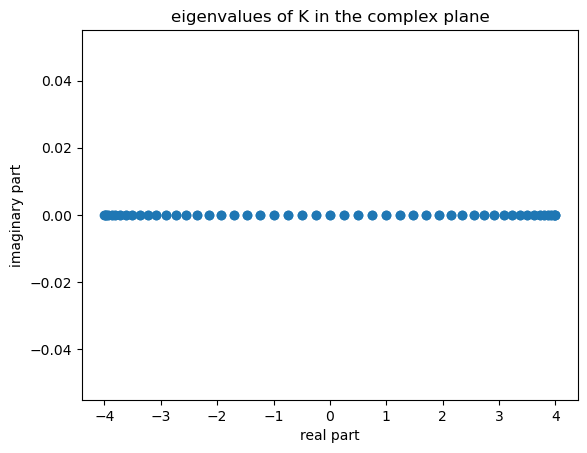

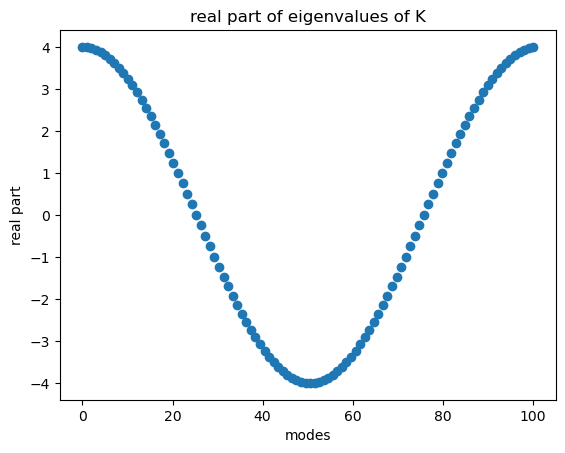

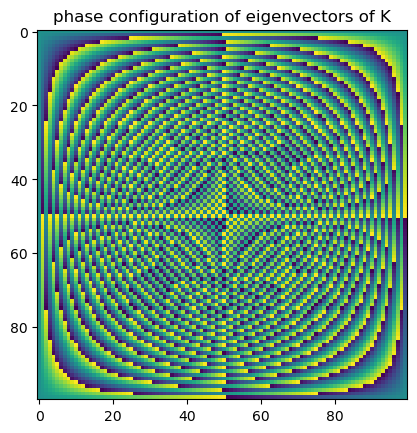

In [22]:
# @title Complex-valued matrix analysis

# Matrix representing the complex system
K = epsilon * np.exp(-1j * phi) * a

# Eigensystem
v, d = circulant_eigensystem(K)

plt.figure()
plt.scatter(np.diag(np.real(d)), np.diag(np.imag(d)))
plt.xlabel('real part')
plt.ylabel('imaginary part')
plt.title('eigenvalues of K in the complex plane')

plt.figure()
plt.scatter(np.linspace(0,N,N),np.diag(np.real(d)))
plt.xlabel('modes')
plt.ylabel('real part')
plt.title('real part of eigenvalues of K')

plt.figure()
plt.imshow(np.angle(v))
plt.title('phase configuration of eigenvectors of K')

In [23]:
# @title Numerical simulation of the KM
# Initial condition
theta0 = np.transpose(np.angle(np.exp(1j*( 0.5*(2 * np.pi * (np.random.rand(1, N) - 0.5)) + np.angle(v[:,2])))))

# numerical simulation of the Kuramoto network
theta_numerical = km_simulation(a, omega, epsilon, theta0.transpose(), t, dt, phi)

/tmp/ipykernel_53854/3325396489.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta[ii, jj] = previous_state[jj] + (dth * dt)


In [24]:
# @title Evaluation of the complex-valued approach
# Evaluate complex-valued approach (propagator)
x = np.zeros((len(t), N), dtype=complex)
theta_cv = np.zeros((len(t), N))
theta_cv[0,:] = theta0.transpose()
x[0, :] = np.exp(1j * theta0.flatten())  # Initial condition for the first window
propagate = np.exp(1j * (omega[1] * dt)) * expm(K*dt)

for jj in range(1, len(t)):
    previous_state = np.angle(x[jj - 1, :])
    x[jj, :] = np.dot(propagate , np.exp(1j * previous_state))
    theta_cv[jj,:] = np.angle(x[jj, :]/np.abs(x[jj,:]))

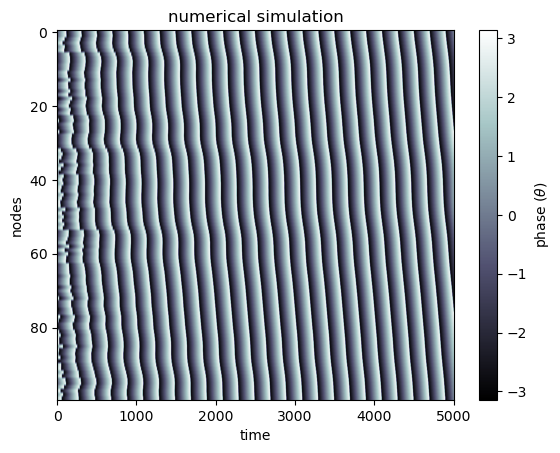

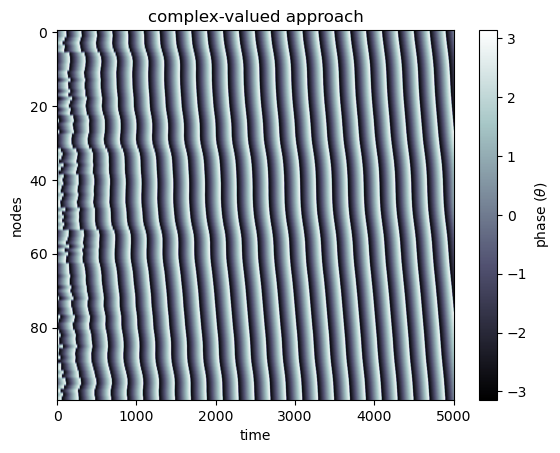

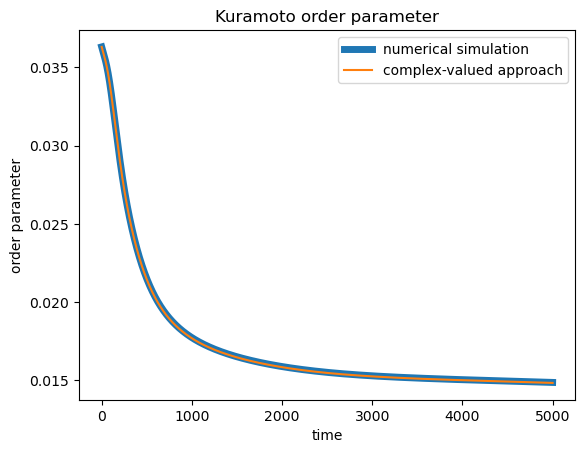

In [26]:
# @title Visualization of the dynamics
# visualization of the dynamics
plt.figure()
plt.imshow(np.transpose(theta_numerical), aspect='auto', cmap = 'bone')
plt.xlabel('time')
plt.ylabel('nodes')
plt.colorbar(label='phase ($\\theta$)')
plt.title('numerical simulation')

plt.figure()
plt.imshow(np.transpose(theta_cv), aspect='auto', cmap = 'bone')
plt.xlabel('time')
plt.ylabel('nodes')
plt.colorbar(label='phase ($\\theta$)')
plt.title('complex-valued approach')


#order parameter
r_num = order_parameter(theta_numerical,N)
r_cv = order_parameter(theta_cv,N)
plt.figure()
plt.plot(r_num, linewidth=5, label='numerical simulation')
plt.plot(r_cv, label='complex-valued approach')
plt.title('Kuramoto order parameter')
plt.xlabel('time')
plt.ylabel('order parameter')
plt.legend()


In the third example, we consider a distance-dependent network with phase-lag in the interaction term. This kind of network is known to display transient chimera states

In [27]:
# @title Defining parameters
# Parameters
dt = 0.001
T = 5.0
t = np.arange(0, T + dt, dt)  # Time array
N = 100                       # Number of oscillators
epsilon = 10                   # Coupling strength
phi = 1.35                      # Phase-lag
f_mu = 5                      # Natural frequency (Hz)
omega = np.ones((N, 1)) * f_mu * 2 * np.pi  # Natural frequency array


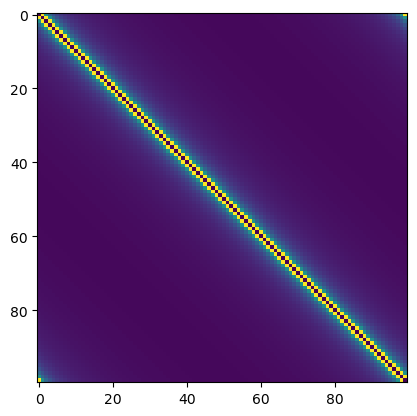

In [28]:
# @title Creating network
# Adjacency matrix

alpha = 1.0; #power-law exponent
a = distance_dependent_graph(N,alpha)

plt.figure()
plt.imshow(a)

Text(0.5, 1.0, 'phase configuration of eigenvectors of K')

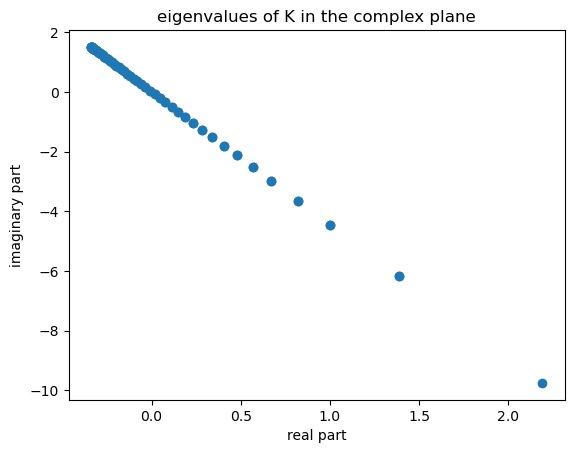

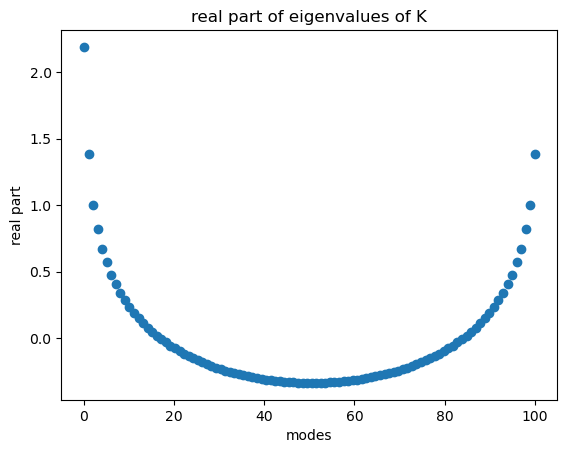

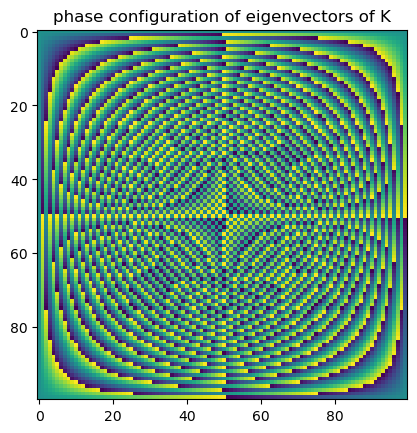

In [29]:
# @title Complex-valued matrix analysis

# Matrix representing the complex system
K = epsilon * np.exp(-1j * phi) * a

# Eigensystem
v, d = circulant_eigensystem(K)

plt.figure()
plt.scatter(np.diag(np.real(d)), np.diag(np.imag(d)))
plt.xlabel('real part')
plt.ylabel('imaginary part')
plt.title('eigenvalues of K in the complex plane')

plt.figure()
plt.scatter(np.linspace(0,N,N),np.diag(np.real(d)))
plt.xlabel('modes')
plt.ylabel('real part')
plt.title('real part of eigenvalues of K')

plt.figure()
plt.imshow(np.angle(v))
plt.title('phase configuration of eigenvectors of K')

In [30]:
# @title Numerical simulation of the KM
# Initial condition
theta0 = 2 * np.pi * (np.random.rand(N, 1) - 0.5)

# numerical simulation of the Kuramoto network
theta_numerical = km_simulation(a, omega, epsilon, theta0.transpose(), t, dt, phi)

/tmp/ipykernel_53854/3325396489.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta[ii, jj] = previous_state[jj] + (dth * dt)


In [31]:
# @title Evaluation of the complex-valued approach
# Evaluate complex-valued approach (propagator)
x = np.zeros((len(t), N), dtype=complex)
theta_cv = np.zeros((len(t), N))
theta_cv[0,:] = theta0.transpose()
x[0, :] = np.exp(1j * theta0.flatten())  # Initial condition for the first window
propagate = np.exp(1j * (omega[1] * dt)) * expm(K*dt)

for jj in range(1, len(t)):
    previous_state = np.angle(x[jj - 1, :])
    x[jj, :] = np.dot(propagate , np.exp(1j * previous_state))
    theta_cv[jj,:] = np.angle(x[jj, :]/np.abs(x[jj,:]))

Text(0.5, 1.0, 'Kuramoto order parameter')

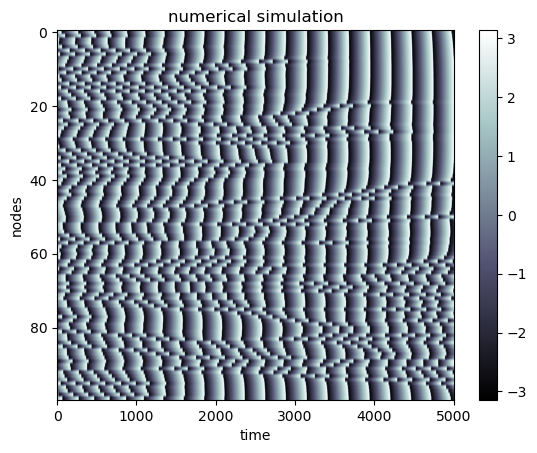

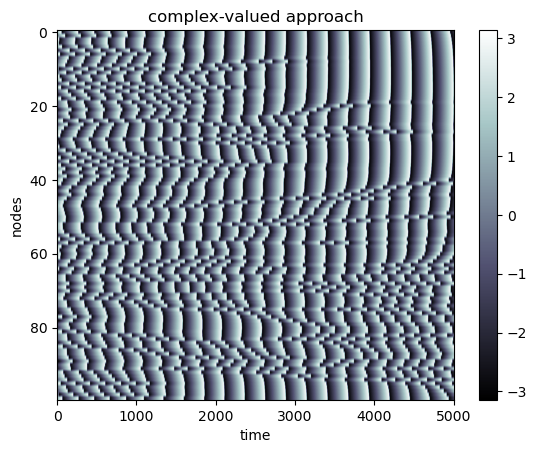

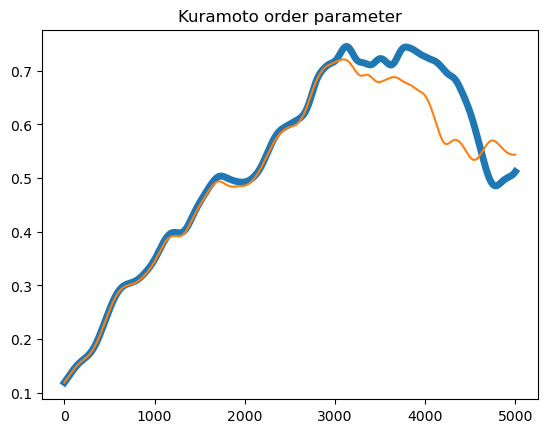

In [32]:
# @title Visualization of the dynamics
# visualization of the dynamics
plt.figure()
plt.imshow(np.transpose(theta_numerical), aspect='auto', cmap = 'bone')
plt.xlabel('time')
plt.ylabel('nodes')
plt.colorbar()
plt.title('numerical simulation')

plt.figure()
plt.imshow(np.transpose(theta_cv), aspect='auto', cmap = 'bone')
plt.xlabel('time')
plt.ylabel('nodes')
plt.colorbar()
plt.title('complex-valued approach')


#order parameter
r_num = order_parameter(theta_numerical,N)
r_cv = order_parameter(theta_cv,N)
plt.figure()
plt.plot(r_num, linewidth=5)
plt.plot(r_cv)
plt.title('Kuramoto order parameter')
